# **Lifetimes**

## Setup

In [1]:
import pandas as pd
import lifetimes
import datetime
import numpy as np
import scikit
# Charting
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots


import plotly.io as pio
pio.renderers.default = "notebook_connected"

In [2]:
raw_df = pd.read_pickle('df.pickle')

In [3]:
def clean(df):
    df = df[df['Fecha'] >= (max(df['Fecha']) - datetime.timedelta(455))]
    df = df[df['Valor FOB'] > 0]

    df = df[[
        'Cliente', 
        'Fecha',
        'Valor FOB'
        ]]

    df['T'] = max(df['Fecha']) - df['Fecha']
    df['T'] = df['T'].dt.days

    df['log_MV'] = np.log10(df['Valor FOB'])
    
    return df
df = clean(raw_df)
df.head()

,Cliente,Fecha,Valor FOB,T,log_MV
0,BANCO MULTIPLE BHD LEÓN S.A.,2022-01-31,13198.0100,0,4.120508
2,CONSUMIDOR FINAL FISICO,2022-01-20,579200.0000,11,5.762829
1,ASOCIACION POPULAR DE AHORROS Y PRESTAMOS,2022-01-20,28862.6944,11,4.460337
3,LARC CONSULTORIA Y REDISENO ORGANIZACIONAL SRL,2022-01-19,6019.5200,12,3.779562
4,BANCO POPULAR DOMINICANO,2022-01-14,90011.4243,17,4.954298


## Visualize data

### Ventas

#### Normal

In [86]:
# Histogram Monetary Value
def histogram_Monetary_Value(df):
    df = df.copy()
    fig = px.histogram(df, x="Valor FOB")

    
    fig.update_layout(
        title_text='Cantidad de clientes por Ventas', # title of plot
        xaxis_title_text='Pesos', # xaxis label
        yaxis_title_text='Cantidad', # yaxis label
        bargap=0.2, # gap between bars of adjacent location coordinates
        bargroupgap=0.1 # gap between bars of the same location coordinates)
        )

    fig.show()
histogram_Monetary_Value(df)

#### Transformado

In [94]:
# Histogram log(Monetary Value)
def histogram_log_MV(df):
    df = df.copy()
    fig = px.histogram(
        df, 
        x="log_MV",
        color_discrete_sequence=['indianred'] # color of histogram bars
    )

    
    fig.update_layout(
        title_text='Cantidad de clientes por Ventas', # title of plot
        xaxis_title_text='ln(Pesos)', # xaxis label
        yaxis_title_text='Cantidad', # yaxis label
        bargap=0.2, # gap between bars of adjacent location coordinates
        bargroupgap=0.1, # gap between bars of the same location coordinates)
        )

    fig.show()
histogram_log_MV(df)

### Edad

#### Normal

In [89]:
# Histogram T
def histogram_T(df):
    fig = px.histogram(df, x="T")
    
    fig.update_layout(
        title_text='Cantidad de clientes por Edad', # title of plot
        xaxis_title_text='Edad en Dias', # xaxis label
        yaxis_title_text='Cantidad', # yaxis label
        bargap=0.2, # gap between bars of adjacent location coordinates
        bargroupgap=0.1 # gap between bars of the same location coordinates)
        )

    fig.show()
histogram_T(df)

#### Transformado

In [99]:
# Histogram T
def histogram_T(df):
    plot_df = np.log(df['T'])

    fig = px.histogram(plot_df, x="T", color_discrete_sequence=['indianred'])
    
    fig.update_layout(
        title_text='Cantidad de clientes por Edad', # title of plot
        xaxis_title_text='Edad en Dias', # xaxis label
        yaxis_title_text='Cantidad', # yaxis label
        bargap=0.2, # gap between bars of adjacent location coordinates
        bargroupgap=0.1 # gap between bars of the same location coordinates)
        )

    fig.show()

histogram_T(rfm)

## Transform data as RFM

In [192]:
def get_log_frequency(df):
    df = df.copy().groupby(by=['Cliente']).count()['Fecha']
    df.name = 'frequency'
    df = df.sort_values(ascending=False)
    # array = np.where(df<=1,0,np.log(df))
    # df = pd.DataFrame(array, columns=['log_freq'], index=df.index)
    return df

get_log_frequency(df).value_counts().reset_index()

,index,frequency
0,1,54
1,3,19
2,2,17
3,4,10
4,10,3
5,7,2
6,5,2
7,31,1
8,30,1
9,25,1


### Custom transform

In [204]:
plot_df = get_log_frequency(df).value_counts().reset_index()

plot_df['log_i'] = np.log(plot_df['index'])
plot_df['log_f'] = np.log(plot_df['frequency'])

# fig = px.bar(plot_df, x='index',y='frequency')
fig = px.bar(plot_df, x='log_i',y='frequency')
# fig = px.bar(plot_df, x='log_i',y='log_f')

fig.update_layout(
    title_text='Cantidad de clientes por # de transacciones', # title of plot
    xaxis_title_text='# de transacciones', # xaxis label
    yaxis_title_text='Cantidad', # yaxis label
    )

fig.show()

In [165]:
rng = range(0,10,1)
px.line(x=rng, y=np.log(rng)).show()

C:\Users\Dasa\AppData\Local\Temp\ipykernel_21268\1077316853.py:2: RuntimeWarning:

divide by zero encountered in log



In [174]:
def get_rfm(df):
    def get_frequecy(df):
        df = df.copy().groupby(by=['Cliente']).count()['Fecha']-1
        df.name = 'frequency'
        df = df.sort_values(ascending=False)
        return df

    def get_recency(df):
        df = df.copy().groupby(by=['Cliente']).min()['T']
        df.name = 'recency'
        df = df.sort_values(ascending=False)
        return df

    def get_T(df):
        df = df.copy().groupby(by=['Cliente']).max()['T']
        df.name = 'T'
        df = df.sort_values(ascending=False)
        return df

    def get_Monetary_Value(df):
        df = df.copy().groupby(by=['Cliente']).mean()['Valor FOB']
        df.name = 'Monetary_Value'
        df = df.sort_values(ascending=False)
        return df

    def get_log_frequency(df):
        df = df.copy().groupby(by=['Cliente']).count()['Fecha']-1
        array = np.where(df<=1,0,np.log(df))
        df = pd.DataFrame(array, columns=['log_freq'], index=df.index)
        return df

    def get_log_Monetary_Value(df):
        df = df.copy().groupby(by=['Cliente']).mean()['log_MV']
        df.name = 'log_MV'
        df = df.sort_values(ascending=False)
        return df

    freq = get_frequecy(df)
    rec = get_recency(df)
    T = get_T(df)
    mon = get_Monetary_Value(df)
    log_freq = get_log_frequency(df)
    log_MV = get_log_Monetary_Value(df)

    rfm = pd.concat([freq, rec, T, mon, log_freq, log_MV], axis=1)
    return rfm

rfm = get_rfm(df)
rfm

c:\Users\Dasa\Documents\Programacion\ergotec-clientes\venv\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning:

divide by zero encountered in log



,frequency,recency,T,Monetary_Value,log_freq,log_MV
Cliente,,,,,,
BANCO POPULAR DOMINICANO,30,17,454,3.317455e+05,3.401197,5.248427
ASOCIACION POPULAR DE AHORROS Y PRESTAMOS,29,11,454,6.054839e+05,3.367296,5.196117
CONSUMIDOR FINAL FISICO,24,11,439,5.971923e+05,3.178054,4.597262
ASOCIACION CIBAO DE AHORROS Y PRESTAMOS,10,20,298,1.859375e+06,2.302585,5.482349
BANCO CENTRAL DE LA REPUBLICA DOMINICANA,9,55,439,4.126602e+05,2.197225,5.128952
...,...,...,...,...,...,...
GRUPO SANTOS MOREL GSM SRL,0,48,48,9.597606e+03,0.000000,3.982163
GRUPO A M SRL,0,90,90,5.940900e+03,0.000000,3.773852
GREEN MAN DESIGNS,0,47,47,5.948977e+03,0.000000,3.774442


In [175]:
def pie_frequency(df):
    df = df.groupby(by=['log_freq']).count()['T']
    # return df
    px.pie(df, color=df.index, values='T').show()
pie_frequency(rfm)

In [177]:
# Histogram Frequency
def histogram_frequency(df):
    # fig = go.Figure()
    # fig.add_trace(go.Histogram(x=numbers, name="count", texttemplate="%{x}", textfont_size=20))
    fig = go.Figure(data=[go.Histogram(x=df['log_freq'], cumulative_enabled=True)])
    # fig = px.histogram(df, x="frequency", cumulative_enabled=True)
    
    fig.update_layout(
        title_text='Cantidad de clientes por # de transacciones', # title of plot
        xaxis_title_text='# de transacciones', # xaxis label
        yaxis_title_text='Cantidad', # yaxis label
        # bargap=0.2, # gap between bars of adjacent location coordinates
        # bargroupgap=0.1 # gap between bars of the same location coordinates)
        )

    fig.show()
histogram_frequency(rfm)

In [178]:
# Histogram Frequency
def histogram_frequency(df):
    # df = np.log(df['frequency'])

    fig = px.histogram(df, x="log_freq")
    
    fig.update_layout(
        title_text='Cantidad de clientes por # de transacciones', # title of plot
        xaxis_title_text='# de transacciones', # xaxis label
        yaxis_title_text='Cantidad', # yaxis label
        bargap=0.2, # gap between bars of adjacent location coordinates
        bargroupgap=0.1 # gap between bars of the same location coordinates)
        )

    fig.show()
histogram_frequency(rfm)

In [6]:
# Histogram Recency
def histogram_recency(df):
    fig = px.histogram(df, x="recency")
    
    fig.update_layout(
        title_text='Cantidad de clientes por dias desde ultima venta', # title of plot
        xaxis_title_text='Dias', # xaxis label
        yaxis_title_text='Cantidad', # yaxis label
        bargap=0.2, # gap between bars of adjacent location coordinates
        bargroupgap=0.1 # gap between bars of the same location coordinates)
        )

    fig.show()
histogram_recency(rfm)

### with library

##### sin log

In [13]:
from lifetimes.utils import summary_data_from_transaction_data

xaction_RFM = summary_data_from_transaction_data(
    df,
    'Cliente', 
    'Fecha', 
    'log_MV',
    # observation_period_end='2011-12-09'
)

xaction_RFM.head()

,frequency,recency,T,monetary_value
Cliente,,,,
PRODUCTOS QUÍMICOS INDUSTRIALES,0.0,0.0,207.0,0.000000
STRATEGY SOLUTIONS,0.0,0.0,257.0,0.000000
Trailer Services SRL,0.0,0.0,181.0,0.000000
ADMINISTRADORA DE RIESGOS DE SALUD DR YUNEN S A,0.0,0.0,319.0,0.000000
AES ANDRES DR S A,2.0,358.0,405.0,8.143312


#### con log

In [40]:
from lifetimes.utils import summary_data_from_transaction_data

xaction_RFM = summary_data_from_transaction_data(
    df,
    'Cliente', 
    'Fecha', 
    'Valor FOB',
    # observation_period_end='2011-12-09'
)

xaction_RFM.head()

,frequency,recency,T,monetary_value
Cliente,,,,
PRODUCTOS QUÍMICOS INDUSTRIALES,0.0,0.0,207.0,0.0000
STRATEGY SOLUTIONS,0.0,0.0,257.0,0.0000
Trailer Services SRL,0.0,0.0,181.0,0.0000
ADMINISTRADORA DE RIESGOS DE SALUD DR YUNEN S A,0.0,0.0,319.0,0.0000
AES ANDRES DR S A,2.0,358.0,405.0,524281.5966


In [44]:
#Handle negative and zero values so as to handle infinite numbers during log transformation
def handle_neg_n_zero(num):
    if num <= 0:
        return 1
    else:
        return num
#Apply handle_neg_n_zero function to Recency and Monetary columns 
xaction_RFM['recency'] = [handle_neg_n_zero(x) for x in xaction_RFM.recency]
xaction_RFM['frequency'] = [handle_neg_n_zero(x) for x in xaction_RFM.frequency]
xaction_RFM['monetary_value'] = [handle_neg_n_zero(x) for x in xaction_RFM.monetary_value]

#Perform Log transformation to bring data into normal or near normal distribution
Log_Tfd_Data = xaction_RFM[['recency', 'frequency', 'monetary_value']].apply(np.log, axis = 1).round(3)
Log_Tfd_Data

,recency,frequency,monetary_value
Cliente,,,
PRODUCTOS QUÍMICOS INDUSTRIALES,0.000,0.000,0.000
STRATEGY SOLUTIONS,0.000,0.000,0.000
Trailer Services SRL,0.000,0.000,0.000
ADMINISTRADORA DE RIESGOS DE SALUD DR YUNEN S A,0.000,0.000,0.000
AES ANDRES DR S A,5.881,0.693,13.170
...,...,...,...
UNION COMERCIAL CONSOLIDADA S A,0.000,0.000,0.000
UNION MEDICA DEL NORTE SAS,0.000,0.000,0.000
VIP MULTIPLEX PLAZA SRL,4.477,0.000,9.689


In [45]:
# Histogram Frequency
def histogram_frequency(df):
    fig = px.histogram(df, x="frequency")
    
    fig.update_layout(
        title_text='Cantidad de clientes por # de transacciones', # title of plot
        xaxis_title_text='# de transacciones', # xaxis label
        yaxis_title_text='Cantidad', # yaxis label
        bargap=0.2, # gap between bars of adjacent location coordinates
        bargroupgap=0.1 # gap between bars of the same location coordinates)
        )

    fig.show()
histogram_frequency(Log_Tfd_Data)

In [46]:
# Histogram Recency
def histogram_recency(df):
    fig = px.histogram(df, x="recency")
    
    fig.update_layout(
        title_text='Cantidad de clientes por dias desde ultima venta', # title of plot
        xaxis_title_text='Dias', # xaxis label
        yaxis_title_text='Cantidad', # yaxis label
        bargap=0.2, # gap between bars of adjacent location coordinates
        bargroupgap=0.1 # gap between bars of the same location coordinates)
        )

    fig.show()
histogram_recency(Log_Tfd_Data)

In [50]:
# Histogram Monetary Value
def histogram_Monetary_Value(df):
    df = df.copy()
    # df['Monetary_Value'] = np.log10(df['Monetary_Value'])
    fig = px.histogram(df, x="monetary_value")
    # fig = px.histogram(df, x="Monetary_Value")

    
    fig.update_layout(
        title_text='Cantidad de clientes por Ventas', # title of plot
        xaxis_title_text='Pesos', # xaxis label
        yaxis_title_text='Cantidad', # yaxis label
        bargap=0.2, # gap between bars of adjacent location coordinates
        bargroupgap=0.1 # gap between bars of the same location coordinates)
        )

    fig.show()
histogram_Monetary_Value(Log_Tfd_Data)

## K-means clustering

### Scale data

In [115]:
from sklearn.preprocessing import StandardScaler

#Bring the data on same scale
scaleobj = StandardScaler()
Scaled_Data = scaleobj.fit_transform(rfm)

#Transform it back to dataframe
Scaled_Data = pd.DataFrame(Scaled_Data, index = rfm.index, columns = rfm.columns)

In [116]:
Scaled_Data

,frequency,recency,T,Monetary_Value,log_MV
Cliente,,,,,
BANCO POPULAR DOMINICANO,5.903997,-1.277812,1.662847,-0.096460,0.563447
ASOCIACION POPULAR DE AHORROS Y PRESTAMOS,5.692405,-1.329523,1.662847,0.184993,0.478618
CONSUMIDOR FINAL FISICO,4.634441,-1.329523,1.545453,0.176467,-0.492519
ASOCIACION CIBAO DE AHORROS Y PRESTAMOS,1.672144,-1.251957,0.441944,1.474223,0.942789
BANCO CENTRAL DE LA REPUBLICA DOMINICANA,1.460551,-0.950313,1.545453,-0.013265,0.369700
...,...,...,...,...,...
GRUPO SANTOS MOREL GSM SRL,-0.443783,-1.010642,-1.514633,-0.427687,-1.489997
GRUPO A M SRL,-0.443783,-0.648668,-1.185928,-0.431447,-1.827805
GREEN MAN DESIGNS,-0.443783,-1.019260,-1.522459,-0.431439,-1.826848


### Modeling

In [117]:
from sklearn.cluster import KMeans

sum_of_sq_dist = {}
for k in range(1,15):
    km = KMeans(n_clusters= k, init= 'k-means++', max_iter= 1000)
    km = km.fit(Scaled_Data)
    sum_of_sq_dist[k] = km.inertia_

### Plot

In [118]:
#Plot the graph for the sum of square distance values and Number of Clusters

fig = px.line(
    x = list(sum_of_sq_dist.keys()),
    y = list(sum_of_sq_dist.values()),
    title = 'Elbow Method For Optimal k',
    markers = True
    # mode = 'markers+lines'
)

fig.update_layout(
    title_text='Cantidad de clientes por # de transacciones', # title of plot
    xaxis_title_text='# de transacciones', # xaxis label
    yaxis_title_text='Cantidad', # yaxis label
    bargap=0.2, # gap between bars of adjacent location coordinates
    bargroupgap=0.1 # gap between bars of the same location coordinates)
)

fig.show()

### Cluster in df

In [131]:
#Perform K-Mean Clustering or build the K-Means clustering model
KMean_clust = KMeans(n_clusters= 3, init= 'k-means++', max_iter= 1000)
KMean_clust.fit(Scaled_Data)

#Find the clusters for the observation given in the dataset
rfm['Cluster'] = KMean_clust.labels_
Scaled_Data['Cluster'] = KMean_clust.labels_
Scaled_Data.head()

,frequency,recency,T,Monetary_Value,log_MV,Cluster
Cliente,,,,,,
BANCO POPULAR DOMINICANO,5.903997,-1.277812,1.662847,-0.096460,0.563447,1
ASOCIACION POPULAR DE AHORROS Y PRESTAMOS,5.692405,-1.329523,1.662847,0.184993,0.478618,1
CONSUMIDOR FINAL FISICO,4.634441,-1.329523,1.545453,0.176467,-0.492519,1
ASOCIACION CIBAO DE AHORROS Y PRESTAMOS,1.672144,-1.251957,0.441944,1.474223,0.942789,1
BANCO CENTRAL DE LA REPUBLICA DOMINICANA,1.460551,-0.950313,1.545453,-0.013265,0.369700,1


### Plot clusters

In [133]:
Scaled_Data.Cluster = Scaled_Data.Cluster.astype(str)
Scaled_Data.sort_values(by=['Cluster'], inplace=True)

In [137]:
# plot_df = rfm[
    # (rfm['Monetary_Value'] < 7000000)
    # &
    # (rfm['frequency'] < 20)
    # &
    # (rfm['frequency'] > 0)
# ]
plot_df = rfm

fig = px.scatter_3d(
    plot_df,
    x = 'recency',
    y = 'frequency',
    z = 'log_MV',
    color = 'Cluster'
)

fig.update_layout(
    # xaxis = dict(autorange="reversed")
)

fig.show()

In [135]:
fig = px.scatter(rfm, x='recency',y='log_MV', color='Cluster').show()

## Training Model to det. 'Alive-ness'

In [14]:
from lifetimes import BetaGeoFitter

I2 = 0.0004

bgf = BetaGeoFitter(penalizer_coef = I2)
bgf.fit(xaction_RFM['frequency'], xaction_RFM['recency'], xaction_RFM['T'])

<lifetimes.BetaGeoFitter: fitted with 113 subjects, a: 0.22, alpha: 93.22, b: 0.93, r: 0.58>

### Visualizing Model Frequency/Recency Matrix

<AxesSubplot:title={'center':'Expected Number of Future Purchases for 1 Unit of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

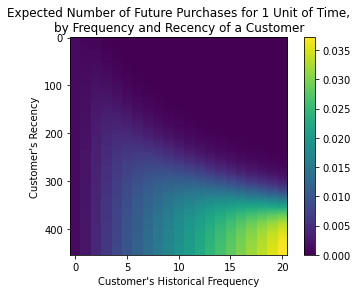

In [15]:
# Recency_Frequency Plot
from lifetimes.plotting import plot_frequency_recency_matrix
plot_frequency_recency_matrix(bgf)

<AxesSubplot:title={'center':'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

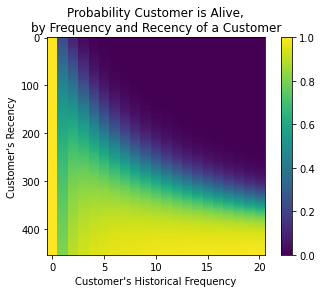

In [16]:
# Still alive plot
from lifetimes.plotting import plot_probability_alive_matrix
plot_probability_alive_matrix(bgf)

### Rank customer from Best to Worst

In [17]:
t = 1  #day(s)
xaction_RFM['predicted_purchase'] = bgf.conditional_expected_number_of_purchases_up_to_time(
    t,
    xaction_RFM['frequency'], 
    xaction_RFM['recency'], 
    xaction_RFM['T']
)
xaction_RFM.sort_values(by='predicted_purchase', ascending=False).head(5)

,frequency,recency,T,monetary_value,predicted_purchase
Cliente,,,,,
ASOCIACION POPULAR DE AHORROS Y PRESTAMOS,20.0,443.0,454.0,7.540103,0.036983
CONSUMIDOR FINAL FISICO,18.0,428.0,439.0,6.183581,0.034285
BANCO POPULAR DOMINICANO,9.0,437.0,454.0,17.518653,0.016940
ASOCIACION CIBAO DE AHORROS Y PRESTAMOS,6.0,278.0,298.0,8.204564,0.015980
BANCO CENTRAL DE LA REPUBLICA DOMINICANA,8.0,384.0,439.0,5.201765,0.015060


In [18]:
t = 3  #day(s)
xaction_RFM['predicted_purchase'] = bgf.conditional_expected_number_of_purchases_up_to_time(
    t,
    xaction_RFM['frequency'], 
    xaction_RFM['recency'], 
    xaction_RFM['T']
)
xaction_RFM.sort_values(by='predicted_purchase', ascending=False).head(5)

,frequency,recency,T,monetary_value,predicted_purchase
Cliente,,,,,
ASOCIACION POPULAR DE AHORROS Y PRESTAMOS,20.0,443.0,454.0,7.540103,0.110905
CONSUMIDOR FINAL FISICO,18.0,428.0,439.0,6.183581,0.102813
BANCO POPULAR DOMINICANO,9.0,437.0,454.0,17.518653,0.050799
ASOCIACION CIBAO DE AHORROS Y PRESTAMOS,6.0,278.0,298.0,8.204564,0.047910
BANCO CENTRAL DE LA REPUBLICA DOMINICANA,8.0,384.0,439.0,5.201765,0.045162


In [19]:
t = 30  #day(s)
xaction_RFM['predicted_purchase'] = bgf.conditional_expected_number_of_purchases_up_to_time(
    t,
    xaction_RFM['frequency'], 
    xaction_RFM['recency'], 
    xaction_RFM['T']
)
xaction_RFM.sort_values(by='predicted_purchase', ascending=False).head(5)

,frequency,recency,T,monetary_value,predicted_purchase
Cliente,,,,,
ASOCIACION POPULAR DE AHORROS Y PRESTAMOS,20.0,443.0,454.0,7.540103,1.103127
CONSUMIDOR FINAL FISICO,18.0,428.0,439.0,6.183581,1.022482
BANCO POPULAR DOMINICANO,9.0,437.0,454.0,17.518653,0.505219
ASOCIACION CIBAO DE AHORROS Y PRESTAMOS,6.0,278.0,298.0,8.204564,0.475426
BANCO CENTRAL DE LA REPUBLICA DOMINICANA,8.0,384.0,439.0,5.201765,0.449080


### Split Data (training & validation)

#### Calibration period histogram

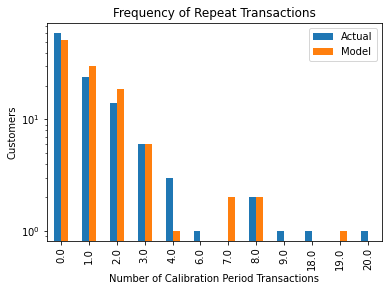

In [22]:
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf, max_frequency=10).set_yscale('log')

#### Cumulative transaction plot

In [23]:
from lifetimes.utils import calibration_and_holdout_data

summary_cal_holdout = calibration_and_holdout_data(
    df,
    'Cliente',
    'Fecha',
    calibration_period_end = (max(df['Fecha']) - datetime.timedelta(45)),
    observation_period_end = max(df['Fecha'])
)

summary_cal_holdout.head()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
Cliente,,,,,
PRODUCTOS QUÍMICOS INDUSTRIALES,0.0,0.0,162.0,0.0,45.0
STRATEGY SOLUTIONS,0.0,0.0,212.0,0.0,45.0
Trailer Services SRL,0.0,0.0,136.0,0.0,45.0
ADMINISTRADORA DE RIESGOS DE SALUD DR YUNEN S A,0.0,0.0,274.0,0.0,45.0
AES ANDRES DR S A,2.0,358.0,360.0,0.0,45.0


In [24]:
bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])

<lifetimes.BetaGeoFitter: fitted with 112 subjects, a: 0.02, alpha: 103.56, b: 0.11, r: 0.67>

<AxesSubplot:title={'center':'Tracking Cumulative Transactions'}, xlabel='day', ylabel='Cumulative Transactions'>

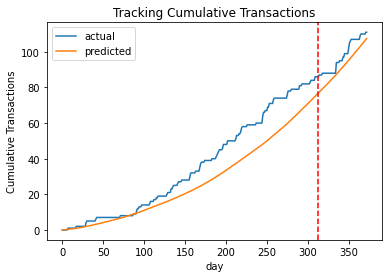

In [25]:
from lifetimes.plotting import plot_cumulative_transactions
plot_cumulative_transactions(bgf, df, 'Fecha', 'Cliente', 373, 313, freq='D')

#### Incremental transaction plot

<AxesSubplot:title={'center':'Tracking Daily Transactions'}, xlabel='day', ylabel='Transactions'>

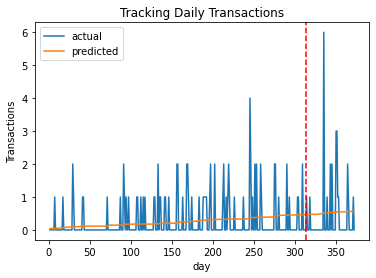

In [26]:
from lifetimes.plotting import plot_incremental_transactions
plot_incremental_transactions(bgf, df, 'Fecha', 'Cliente', 373, 313, freq='D')

#### Conditional expectations plot

<AxesSubplot:title={'center':'Actual Purchases in Holdout Period vs Predicted Purchases'}, xlabel='Purchases in calibration period', ylabel='Average of Purchases in Holdout Period'>

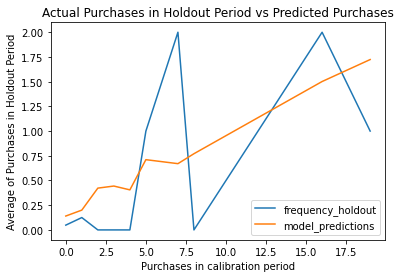

In [27]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout, n=100)

### Predictions

#### Single Customer Prediction
Let's pick some customer and predict what that indivudla's future purchase might look like

In [28]:
t = 3  #predict purchases in 3-days
individual = xaction_RFM.loc['BANCO CENTRAL DE LA REPUBLICA DOMINICANA', :]    # customerID = '13694'
bgf.conditional_expected_number_of_purchases_up_to_time(
    t,
    individual['frequency'], 
    individual['recency'], 
    individual['T']
)

0.04763184813321525

#### Single Customer probability Histories
Given a customer transaction history, we can calculate their historical probability of being alive, according to our trained model.

<AxesSubplot:title={'center':'History of P_alive'}, ylabel='P_alive'>

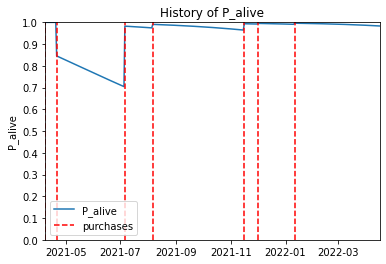

In [29]:
from lifetimes.plotting import plot_history_alive

# customer_ID = 'BANCO CENTRAL DE LA REPUBLICA DOMINICANA'
# customer_ID = 'EMBAJADA DE FRANCIA'
customer_ID = 'ASOCIACION CIBAO DE AHORROS Y PRESTAMOS'




days_since_birth = 373
sp_trans = df.loc[df['Cliente'] == customer_ID]
plot_history_alive(bgf, days_since_birth, sp_trans, 'Fecha')

## Estimating CLV using Gamma-Gamma model
Until now, we have not taken into account the economics value of each transaction; rather, we've only been focusing on transactions' occurences.

In order to estimate CLV, we will use the Gamma-Gama submodel.

First, we shall create summary data from the transactional data that contains the economics values for each transaction (e.g., profits or revenues).

In [32]:
summary_with_money_value = xaction_RFM
returning_customers_summary = summary_with_money_value[summary_with_money_value['frequency']>0]
returning_customers_summary = returning_customers_summary[returning_customers_summary['monetary_value'] > 0]
returning_customers_summary.head()

,frequency,recency,T,monetary_value,predicted_purchase
Cliente,,,,,
AES ANDRES DR S A,2.0,358.0,405.0,8.143312,0.134471
APP QUISQUEYA SRL,2.0,49.0,75.0,5.735682,0.383524
ASOCIACION CIBAO DE AHORROS Y PRESTAMOS,6.0,278.0,298.0,8.204564,0.475426
ASOCIACION POPULAR DE AHORROS Y PRESTAMOS,20.0,443.0,454.0,7.540103,1.103127
BANCO CARIBE,1.0,21.0,74.0,5.204906,0.193856


### Gamma-Gamma Model && Independence Assumptions
The model we are going to use to estimate the CLV for our data is called the Gamma-Gamma submodel, which relies upon an important assumption.

The Gamma-Gamma submodel assumes that there is no relationship between the monetary value and the purchase frequency. In practice we need to check whether the Pearson correlation between the two vectors is close to 0 in order to use this model.

In [33]:
returning_customers_summary[['monetary_value', 'frequency']].corr()

,monetary_value,frequency
monetary_value,1.000000,0.119245
frequency,0.119245,1.000000


### Train Gamma-Gamma model

In [35]:
from lifetimes import GammaGammaFitter

ggf = GammaGammaFitter(penalizer_coef = 0.1)
ggf.fit(
    returning_customers_summary['frequency'],
    returning_customers_summary['monetary_value']
)
ggf

<lifetimes.GammaGammaFitter: fitted with 53 subjects, p: 1.40, q: 0.61, v: 1.20>

### Est. Avg. Transaction Value

In [36]:
ggf.conditional_expected_average_profit(
    returning_customers_summary['frequency'],
    returning_customers_summary['monetary_value']
).head(11)

Cliente
AES ANDRES DR S A                                     10.140698
APP QUISQUEYA SRL                                      7.348533
ASOCIACION CIBAO DE AHORROS Y PRESTAMOS                8.809236
ASOCIACION POPULAR DE AHORROS Y PRESTAMOS              7.706316
BANCO CARIBE                                           8.841954
BANCO CENTRAL DE LA REPUBLICA DOMINICANA               5.542806
BANCO DE RESERVAS DE LA REPUBLICA DOMINICANA BANCO    31.014930
BANCO MULTIPLE BHD LEON SA                            17.010191
BANCO MULTIPLE BHD LEÓN S.A.                           7.345326
BANCO POPULAR DOMINICANO                              18.209456
BARNA MANAGEMENT SCHOOl                                8.989600
dtype: float64

In [37]:
print(
    "Expected conditional average revenue: %s, Average revenue: %s" % (
        ggf.conditional_expected_average_profit(
            returning_customers_summary['frequency'],
            returning_customers_summary['monetary_value']
        ).mean(),

        summary_with_money_value[summary_with_money_value['frequency']>0]['monetary_value'].mean()
    )
)

Expected conditional average revenue: 9.369211920923604, Average revenue: 6.79362384236142
